In [1]:
try:
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum
    from pyspark.ml.feature import StopWordsRemover, Tokenizer
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns
except:
    print("downloading stuff...")
    %pip install pyspark
    %pip install pandas
    %pip install textblob
    %pip install matplotlib
    %pip install seaborn
    from pyspark.sql import SparkSession
    from pyspark.sql.functions import lower, regexp_replace, col, split, explode, count, sum as spark_sum
    from pyspark.ml.feature import StopWordsRemover, Tokenizer
    import pandas as pd
    from textblob import TextBlob
    import matplotlib.pyplot as plt
    import seaborn as sns

pd.set_option('display.max_colwidth', None)

In [2]:
def show_pandas_df(spark_df, limit, *columns):
    if not columns:
        return spark_df.limit(limit).toPandas()
    else:
        return spark_df.select(*columns).limit(limit).toPandas()

In [3]:
spark = SparkSession.builder \
    .appName("EiffelTowerTweetsAnalysis 1") \
    .getOrCreate()

selected = spark.read.json("../../datasets/eiffel-tower-reviews.json").select('title', 'text')

show_pandas_df(
    selected,
    10,
)


,title,text
0,Must do even it was so busy,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris
1,A Classic,"My significant other and I drunkenly stumbled here a few weeks back. For a 'cliche' type experience it certainly was absolutely incredible. We popped in around 2200, and the Tower was beautifully lit. The view from the top is fantastic, but be prepared to dress warm. Definitely cold up there."
2,Wet weather,"We had a tour to the Eiffel Tower while we were in Paris. Unfortunately one of the cable cars was down while there, which made the wait times a little longer even with skip the queue passes."
3,Not to be missed,Visited with my wife and son.
4,Awesome!!!,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower. It was very very beautiful to see the Eiffel all lit up beautifully. At 10pm there is special illumination which ch starts and last for 5 mins. Its like millions of leds starts blinking. Covering the entire tower. I was awe stuck to see the sight. Must must go.
5,Iconic place for anyone visiting France,Dont hesitate and got all the way up to the top. The view is inspiring. Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset. Make sure to look at the tower from the streets (or Sena river) around 21:00 hours to see some extra lights !!!!!
6,Delightful,"I enjoyed the tower with my kids, and went to the top, beautiful views, with some lovely photos, an iconic building I had to see while there,"
7,Wonderful experience at night,Read through the history of the Eiffel Tower and enjoy it's magnificence twice - once during the day at close quarters and second at night. Wonderful going into history.
8,Wow,This by far was our favourite part of Europe. Nothing can compare to seeing this amazing piece of architecture in real life. It is simply breathtaking? Make this your number one priority on any trip to Europe
9,Great,Something you have to do when you visit Paris. Its a must ☺️. The views are breath taking. Really beautiful


### Limpando colunas

In [4]:
print(selected.count())
titles = selected.select('title').dropna()
texts = selected.select('text').dropna()
print(titles.count())
print(texts.count())


7179
7179
7176


In [5]:
def cleaner(column, column_name):
    return column.withColumn(str(column_name) + "_cleaned", regexp_replace(col(column_name), "[^a-zA-Z0-9 ]", ""))

texts = cleaner(texts, 'text')
show_pandas_df(texts, 10)

,text,text_cleaned
0,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris,This is the most busiest atttaction in Paris and there are some nice restaurants on it and the views were spectacular and this is the top must do in Paris
1,"My significant other and I drunkenly stumbled here a few weeks back. For a 'cliche' type experience it certainly was absolutely incredible. We popped in around 2200, and the Tower was beautifully lit. The view from the top is fantastic, but be prepared to dress warm. Definitely cold up there.",My significant other and I drunkenly stumbled here a few weeks back For a cliche type experience it certainly was absolutely incredible We popped in around 2200 and the Tower was beautifully lit The view from the top is fantastic but be prepared to dress warm Definitely cold up there
2,"We had a tour to the Eiffel Tower while we were in Paris. Unfortunately one of the cable cars was down while there, which made the wait times a little longer even with skip the queue passes.",We had a tour to the Eiffel Tower while we were in Paris Unfortunately one of the cable cars was down while there which made the wait times a little longer even with skip the queue passes
3,Visited with my wife and son.,Visited with my wife and son
4,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower. It was very very beautiful to see the Eiffel all lit up beautifully. At 10pm there is special illumination which ch starts and last for 5 mins. Its like millions of leds starts blinking. Covering the entire tower. I was awe stuck to see the sight. Must must go.,We went in the night at 10pm to see the illumination of Paris that is Eiffel Tower It was very very beautiful to see the Eiffel all lit up beautifully At 10pm there is special illumination which ch starts and last for 5 mins Its like millions of leds starts blinking Covering the entire tower I was awe stuck to see the sight Must must go
5,Dont hesitate and got all the way up to the top. The view is inspiring. Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset. Make sure to look at the tower from the streets (or Sena river) around 21:00 hours to see some extra lights !!!!!,Dont hesitate and got all the way up to the top The view is inspiring Be early in the morning to avoid lines or late in the afternoon to enjoy the sunset Make sure to look at the tower from the streets or Sena river around 2100 hours to see some extra lights
6,"I enjoyed the tower with my kids, and went to the top, beautiful views, with some lovely photos, an iconic building I had to see while there,",I enjoyed the tower with my kids and went to the top beautiful views with some lovely photos an iconic building I had to see while there
7,Read through the history of the Eiffel Tower and enjoy it's magnificence twice - once during the day at close quarters and second at night. Wonderful going into history.,Read through the history of the Eiffel Tower and enjoy its magnificence twice once during the day at close quarters and second at night Wonderful going into history
8,This by far was our favourite part of Europe. Nothing can compare to seeing this amazing piece of architecture in real life. It is simply breathtaking? Make this your number one priority on any trip to Europe,This by far was our favourite part of Europe Nothing can compare to seeing this amazing piece of architecture in real life It is simply breathtaking Make this your number one priority on any trip to Europe
9,Something you have to do when you visit Paris. Its a must ☺️. The views are breath taking. Really beautiful,Something you have to do when you visit Paris Its a must The views are breath taking Really beautiful


In [6]:
titles = cleaner(titles, 'title')
show_pandas_df(titles, 10)

,title,title_cleaned
0,Must do even it was so busy,Must do even it was so busy
1,A Classic,A Classic
2,Wet weather,Wet weather
3,Not to be missed,Not to be missed
4,Awesome!!!,Awesome
5,Iconic place for anyone visiting France,Iconic place for anyone visiting France
6,Delightful,Delightful
7,Wonderful experience at night,Wonderful experience at night
8,Wow,Wow
9,Great,Great


### Mais processo de limpeza
- pegando apenas as palavras nos textos e titulos
- removendo palavras comuns

In [7]:
def get_words(df, input_col, output_col):
    return Tokenizer(inputCol=input_col, outputCol=output_col).transform(df).select(output_col)

def remove_stop_words(df, input_col, output_col):
    return StopWordsRemover(inputCol=input_col, outputCol=output_col).transform(df).select(output_col)

def count_words(df):
    return df.groupBy("word").agg(count("word").alias("count")).orderBy("count", ascending=False)


not_filtered_text_words = get_words(texts, "text_cleaned", "words")
filtered_text_words = remove_stop_words(not_filtered_text_words, "words", "filtered_words")

not_filtered_title_words = get_words(titles, "title_cleaned", "words")
filtered_title_words = remove_stop_words(not_filtered_title_words, "words", "filtered_words")

# Exemplo
not_filtered_title_words.show()
filtered_title_words.show()

+--------------------+
|               words|
+--------------------+
|[must, do, even, ...|
|        [a, classic]|
|      [wet, weather]|
|[not, to, be, mis...|
|           [awesome]|
|[iconic, place, f...|
|        [delightful]|
|[wonderful, exper...|
|               [wow]|
|             [great]|
|                [ok]|
|[its, the, eiffel...|
|           [amazing]|
|[one, and, only, ...|
|[long, long, queu...|
|        [incredible]|
|[time, of, day, m...|
|[not, to, be, mis...|
|       [book, ahead]|
|           [amazing]|
+--------------------+
only showing top 20 rows

+--------------------+
|      filtered_words|
+--------------------+
|  [must, even, busy]|
|           [classic]|
|      [wet, weather]|
|            [missed]|
|           [awesome]|
|[iconic, place, a...|
|        [delightful]|
|[wonderful, exper...|
|               [wow]|
|             [great]|
|                [ok]|
|[eiffel, tower, s...|
|           [amazing]|
|       [one, eiffel]|
|[long, long, queu...|
|       

In [8]:
def explode_words(df, input_col):
    return df.select(explode(col(input_col)).alias("word")).filter(col("word") != "")

def count_words(df):
    return df.groupBy("word").agg(count("word").alias("count")).orderBy("count", ascending=False)

exploded_text_words = explode_words(filtered_text_words, "filtered_words")
text_word_counts = count_words(exploded_text_words)

exploded_title_words = explode_words(filtered_title_words, "filtered_words")
title_word_counts = count_words(exploded_title_words)

combined_word_counts = text_word_counts.union(title_word_counts)
final_word_counts = combined_word_counts.groupBy("word").agg(spark_sum("count").alias("total_count")).orderBy("total_count", ascending=False)

final_df = show_pandas_df(final_word_counts, 10)

spark.stop()

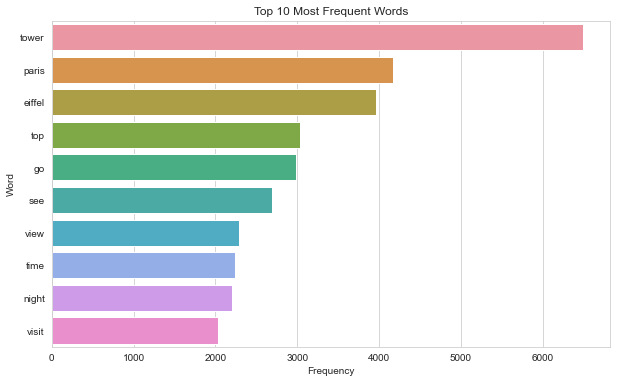

In [9]:
sns.set_style("whitegrid")  
sns.set_palette("viridis")

plt.figure(figsize=(10, 6))
sns.barplot(x="total_count", y="word", data=final_df)

plt.title("Top 10 Most Frequent Words")
plt.xlabel("Frequency")
plt.ylabel("Word")

plt.show()